In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import openai

# loads the .env file
from dotenv import load_dotenv
load_dotenv()

openai.api_key = os.environ.get("OPENAI_API_KEY")

In [2]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "harrywang.me"
full_url = "https://harrywang.me/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://harrywang.me/
https://harrywang.me/blog
https://harrywang.me/iching
https://harrywang.me/assets/files/iching-hexagrams.csv
https://harrywang.me/tag#hobby
https://harrywang.me/tag#research
https://harrywang.me/tag#website
https://harrywang.me/tag#github-pages
https://harrywang.me/tag#crypto
https://harrywang.me/tag#dataset
https://harrywang.me/tag#tutorial
https://harrywang.me/tag#open-source
https://harrywang.me/tag#coding
https://harrywang.me/tag#woodworking
https://harrywang.me/tag#teaching
https://harrywang.me/tag#jekyll
https://harrywang.me/tag#no-code
https://harrywang.me/tag#design
https://harrywang.me/jupyter
https://harrywang.me/scrapy
https://harrywang.me/package
https://harrywang.me/maple-slab
https://harrywang.me/tailpages-intro
http://harrywang.me/tailpages-tutorial-nocode
https://harrywang.me/2022/01/20/tailpages.html
HTTP Error 404: Not Found
http://harrywang.me/2022/01/18/tailpages-tutorial-technical.html
HTTP Error 404: Not Found
https://harrywang.me/tailpages/t

/Users/harrywang/sandbox/ai-tutorials/venv/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [3]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [4]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        #texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

        # don't why omit
        texts.append((file.replace('-',' ').replace('_', ' ').replace('#update',''), text))

text

'Jekyll2023-10-31T19:25:19+00:00https://harrywang.github.io/feed.xmlharrywang.meHarry Wang\'s Personal WebsiteHarry WangMVP (large language Model + Vector database + Prompt engineering)2023-07-14T00:00:00+00:002023-07-14T00:00:00+00:00https://harrywang.github.io/mvp<p><img class="mx-auto" src="https://github.com/harrywang/harrywang.github.io/assets/595772/ae56ce52-ef76-49ba-b9fa-811a75e24963" /></p>\n\n<p>Update (10/7/2023): I revised another “ChatPDF” app using LangChain and Qdrant <a href="https://github.com/harrywang/pdf-ai-assistant">here</a>.</p>\n\n<p>I revised the <a href="https://github.com/openai/openai-cookbook/tree/main/apps/chatbot-kickstarter">sample chatbot kickstarter app</a> developed by <a href="https://www.linkedin.com/in/colin-jarvis-50019658/">Colin Jarvis</a> from OpenAI, which shows how you can create apps (Q&amp;A and Chatbot) using ChatGPT and your own data.</p>\n\n<p>I created a new acronym for this common architecture used for ChatGPT-based apps:</p>\n\n<block

In [5]:
# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])
# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv', escapechar='\\')
df.head()

,fname,text
0,arrywang.me.txt,arrywang.me.txt. Home | harrywang.me ha...
1,harrywang.me tailpages.txt,harrywang.me tailpages.txt. Home | Tailpage...
2,harrywang.me tag#no code.txt,harrywang.me tag#no code.txt. Tags | harryw...
3,harrywang.me tag#hobby.txt,harrywang.me tag#hobby.txt. Tags | harrywan...
4,harrywang.me color.txt,harrywang.me color.txt. Color + Culture + A...


<Axes: >

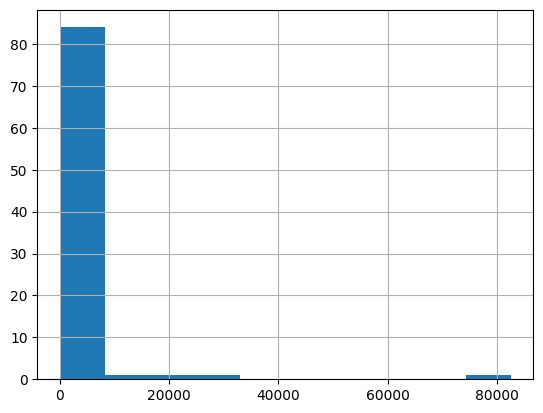

In [6]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [7]:
df.head()

,title,text,n_tokens
0,arrywang.me.txt,arrywang.me.txt. Home | harrywang.me ha...,40
1,harrywang.me tailpages.txt,harrywang.me tailpages.txt. Home | Tailpage...,52
2,harrywang.me tag#no code.txt,harrywang.me tag#no code.txt. Tags | harryw...,689
3,harrywang.me tag#hobby.txt,harrywang.me tag#hobby.txt. Tags | harrywan...,689
4,harrywang.me color.txt,harrywang.me color.txt. Color + Culture + A...,584


In [8]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

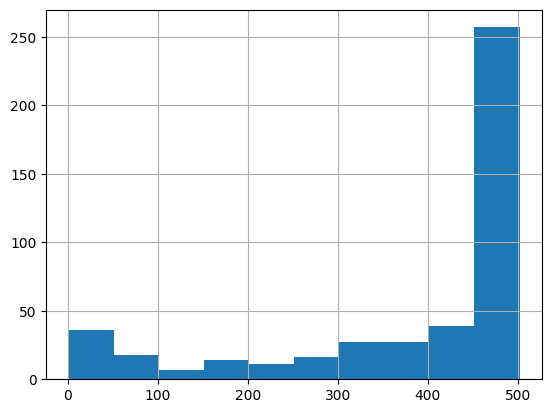

In [9]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [10]:
df.head()

,text,n_tokens
0,arrywang.me.txt. Home | harrywang.me ha...,40
1,harrywang.me tailpages.txt. Home | Tailpage...,52
2,harrywang.me tag#no code.txt.,10
3,harrywang.me tag#hobby.txt.,10
4,harrywang.me color.txt. Color + Culture + A...,491


In [11]:
import openai

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,arrywang.me.txt. Home | harrywang.me ha...,40,"[-0.009879526682198048, -0.01025207806378603, ..."
1,harrywang.me tailpages.txt. Home | Tailpage...,52,"[-0.007976964116096497, -0.008979232981801033,..."
2,harrywang.me tag#no code.txt.,10,"[-0.026701314374804497, -0.0016187671571969986..."
3,harrywang.me tag#hobby.txt.,10,"[-0.025605035945773125, -0.00522272614762187, ..."
4,harrywang.me color.txt. Color + Culture + A...,491,"[-0.00012888545461464673, -0.01910432614386081..."


In [15]:
import pandas as pd
import numpy as np
from ast import literal_eval
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,arrywang.me.txt. Home | harrywang.me ha...,40,"[-0.009879526682198048, -0.01025207806378603, ..."
1,harrywang.me tailpages.txt. Home | Tailpage...,52,"[-0.007976964116096497, -0.008979232981801033,..."
2,harrywang.me tag#no code.txt.,10,"[-0.026701314374804497, -0.0016187671571969986..."
3,harrywang.me tag#hobby.txt.,10,"[-0.025605035945773125, -0.00522272614762187, ..."
4,harrywang.me color.txt. Color + Culture + A...,491,"[-0.00012888545461464673, -0.01910432614386081..."


In [16]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="who is harry?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [17]:
answer_question(df, question="who is harry?", debug=False)

'Harry Wang is a Full Professor of Management Information Systems at the University of Delaware with more than 15 years’ research, teaching, and management experience in AI, business intelligence and analytics, business process management, and enterprise systems. He is also an affiliated faculty at the Data Science Institute and the Institute for Financial Services Analytics. He currently serves as the Chief Scientist of Tezign (a unicorn tech startup based in Shanghai backed by VC firms like Sequoia Capital, Hearst Ventures, and Temasek) and an Independent Director for So-Young International Inc. (NASDAQ: SY - the largest social community in China for consumers, professionals, and service providers in the medical aesthetics industry). He was the Founding Director of OneConnect (NYSE:'

In [20]:
answer_question(df, question="what is stable diffusion?", debug=False)

'Stable Diffusion is a AI creativity tool that enables fine-tuning of language models with much lower GPU requirements. It can be used to generate images based on text prompts.'